In [1]:
import os, glob

import numpy as np

import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy import ndimage

import astropy.units as u
from astropy.table import Table, hstack, vstack, Column
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.io.votable import parse_single_table


from tqdm import tqdm_notebook as tqdm

In [2]:
# import os, glob
# import shutil
# import numpy as np

# import matplotlib.pyplot as plt
# from matplotlib.colors import LogNorm
# import matplotlib as mpl
# from matplotlib.pyplot import cm

# import scipy.optimize as op
# import emcee
# import matplotlib.patches as patches
# import pickle
# import healpy as hp

# from specutils.spectra import Spectrum1D, SpectralRegion
# from specutils.fitting import fit_generic_continuum

# from spectral_cube import SpectralCube
# import warnings
# from spectral_cube.utils import SpectralCubeWarning
# warnings.filterwarnings(action='ignore', category=SpectralCubeWarning,
#                         append=True)

# from photutils import CircularAperture, CircularAnnulus

# from scipy.stats import gaussian_kde
# from scipy import interpolate
# from scipy import stats
# from scipy import ndimage
# import scipy.optimize as op
# from scipy.ndimage.morphology import binary_erosion, binary_dilation
# from scipy.interpolate import interp1d

# import pandas as pd

# import itertools

# from sklearn.model_selection import train_test_split

# import astropy.units as u
# from astropy.table import Table, hstack, vstack, Column
# from astropy.io import fits
# from astropy.wcs import WCS
# from astropy.coordinates import SkyCoord
# from astropy.nddata import Cutout2D
# from astropy.modeling import models, fitting
# from astropy.io.votable import parse_single_table
# from astropy.stats import sigma_clipped_stats

# import cmocean
# import cmocean.cm as cmo

# import pandas as pd

# from dustmaps.sfd import SFDQuery
# from dustmaps.bayestar import BayestarQuery
# from dustmaps.planck import PlanckQuery

# from tqdm import tqdm_notebook as tqdm

# from reproject import reproject_interp, reproject_from_healpix

In [3]:
plt.clf()
plt.rcdefaults()

fontScale = 12
params = {'axes.labelsize': fontScale,
        'axes.titlesize': fontScale,
        'font.size': fontScale,
        'xtick.labelsize': fontScale,
        'ytick.labelsize': fontScale,
        'xtick.major.size': 4,
        'xtick.major.width': 1.2,
        'xtick.minor.size': 3,
        'xtick.minor.width': 1.2,
        'ytick.major.size': 4,
        'ytick.major.width': 1.2,
        'ytick.minor.size': 3,
        'ytick.minor.width': 1.2
        }
plt.rcParams.update(params)

<Figure size 432x288 with 0 Axes>

In [4]:
def make_velocity_axis(h):
    """ Creates the velocity axis given a pyfits header. Assumes the third
        axis is the velocity axis in km/s using the radio definition.
        """

    from numpy import arange

    array = (arange(h['NAXIS3']) - h['CRPIX3'] + 1) * h['CDELT3'] + h['CRVAL3']

    return array / 1000.

In [5]:
spec_dir = './spectra_dec20/'
spec_files = glob.glob(spec_dir+'*_spec.vot')

In [6]:
em_spec_dir = './em_spectra_dec20/'
em_spec_files = glob.glob(em_spec_dir+'*_emission.vot')

In [7]:
abs_file = './askap_spectra.vot'
table = parse_single_table(abs_file).array

In [8]:
print('number of absorption spectra: ', len(table['id']))

number of absorption spectra:  373


In [9]:
v_tau = []
tau = []
tau_err = []
ra = []
dec = []

v_tb = []
tb = []
tb_err = []

count = 0
for spec_file in spec_files:
    stable = parse_single_table(spec_file).array

    vel = stable['velocity']
    optd = stable['opacity']
    rms = stable['sigma_opacity']
    
    coord_name = spec_file.split('./spectra_dec20/')[1]
    coord_name = coord_name.split('_spec.vot')[0]
    ras = coord_name.split('-')[0]
    ras = ras[1:3]+'h '+ras[3:5]+'m '+ras[5:7]+'s'
    decs = coord_name.split('-')[1]
    decs = '-'+decs[0:2]+'d '+decs[2:4]+'m '+decs[4:6]+'s'
    coord_str = ras + ' ' + decs
    
    c = SkyCoord(coord_str, frame='icrs')
    rav = c.fk5.ra.degree
    decv = c.fk5.dec.degree
    
    ra.append(rav)
    dec.append(decv)
        
    v_tau = v_tau + [vel]
    tau = tau + [optd]
    tau_err = tau_err + [rms]

    
    em_stable = parse_single_table('./em_spectra_dec20/'+coord_name+'_emission.vot').array
    vel = em_stable['velocity']
    em_mean = em_stable['em_mean']
    em_std = em_stable['em_std']
    
    v_tb = v_tb + [vel]
    tb = tb + [em_mean]
    tb_err = tb_err + [em_std]

v_tau = np.array(v_tau)
tau = np.array(tau)
tau_err = np.array(tau_err)
v_tb = np.array(v_tb)
tb = np.array(tb)
tb_err = np.array(tb_err)

In [10]:
askap_file = 'SMC_askap_parkes_PBC_pilot_K_SM.fits'
askap_cube, askap_header = fits.getdata(askap_file, header=True)
askap_cube = np.squeeze(askap_cube)

# Compute velocity axis
askap_vel = make_velocity_axis(askap_header)

dv_askap = np.abs(askap_vel[1]-askap_vel[0])

# Define WCS 
wcs_askap = WCS(askap_header)

# Strip third axis in new header for N(HI) plot below
askap_h2 = askap_header.copy()
del askap_h2['NAXIS3'] 
askap_h2['NAXIS'] = 2
del askap_h2['CDELT3']
del askap_h2['CRPIX3']
del askap_h2['CRVAL3']
del askap_h2['CTYPE3']
askap_h2['WCSAXES'] = 2
w2 = WCS(askap_h2)

In [11]:
pixcoord = wcs_askap.wcs_world2pix(table['ra'],table['dec'],0, 0)
pixcoord_extract = wcs_askap.wcs_world2pix(ra,dec,0, 0)

In [12]:
nhi_askap = np.nansum(askap_cube, axis=0)*dv_askap*0.01823

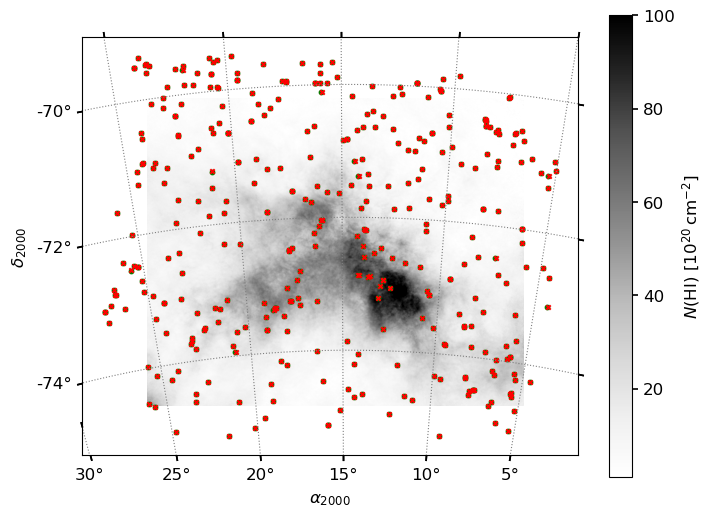

In [13]:
fig = plt.figure(0,[8,6])
ax = fig.add_subplot(111, projection=w2)

ccmap = 'Greys'

dv_askap = np.abs(askap_vel[1]-askap_vel[0])

im = ax.imshow(nhi_askap, cmap=ccmap, vmin=1, vmax=100, origin='lower')
ax.scatter(pixcoord[0], pixcoord[1], marker='o', s=10, color='green', zorder=1)
ax.scatter(pixcoord_extract[0], pixcoord_extract[1], marker='x', s=10, color='red', zorder=1)


ax.set_xlabel(r'$\alpha_{2000}$')
ax.set_ylabel(r'$\delta_{2000}$')

raax = ax.coords['ra']
decax = ax.coords['dec']
raax.set_major_formatter('dd')
decax.set_major_formatter('dd') 
ax.grid(color='grey', ls='dotted', zorder=1)

plt.colorbar(im, label=r'$N({\rm HI})\,\,[\rm 10^{20}\,cm^{-2}]$')
plt.savefig('nhi_absorption_targets.pdf', format='pdf')

<ipython-input-14-bb5ec5b73317>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(spec_files))):


<ipython-input-14-bb5ec5b73317>:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


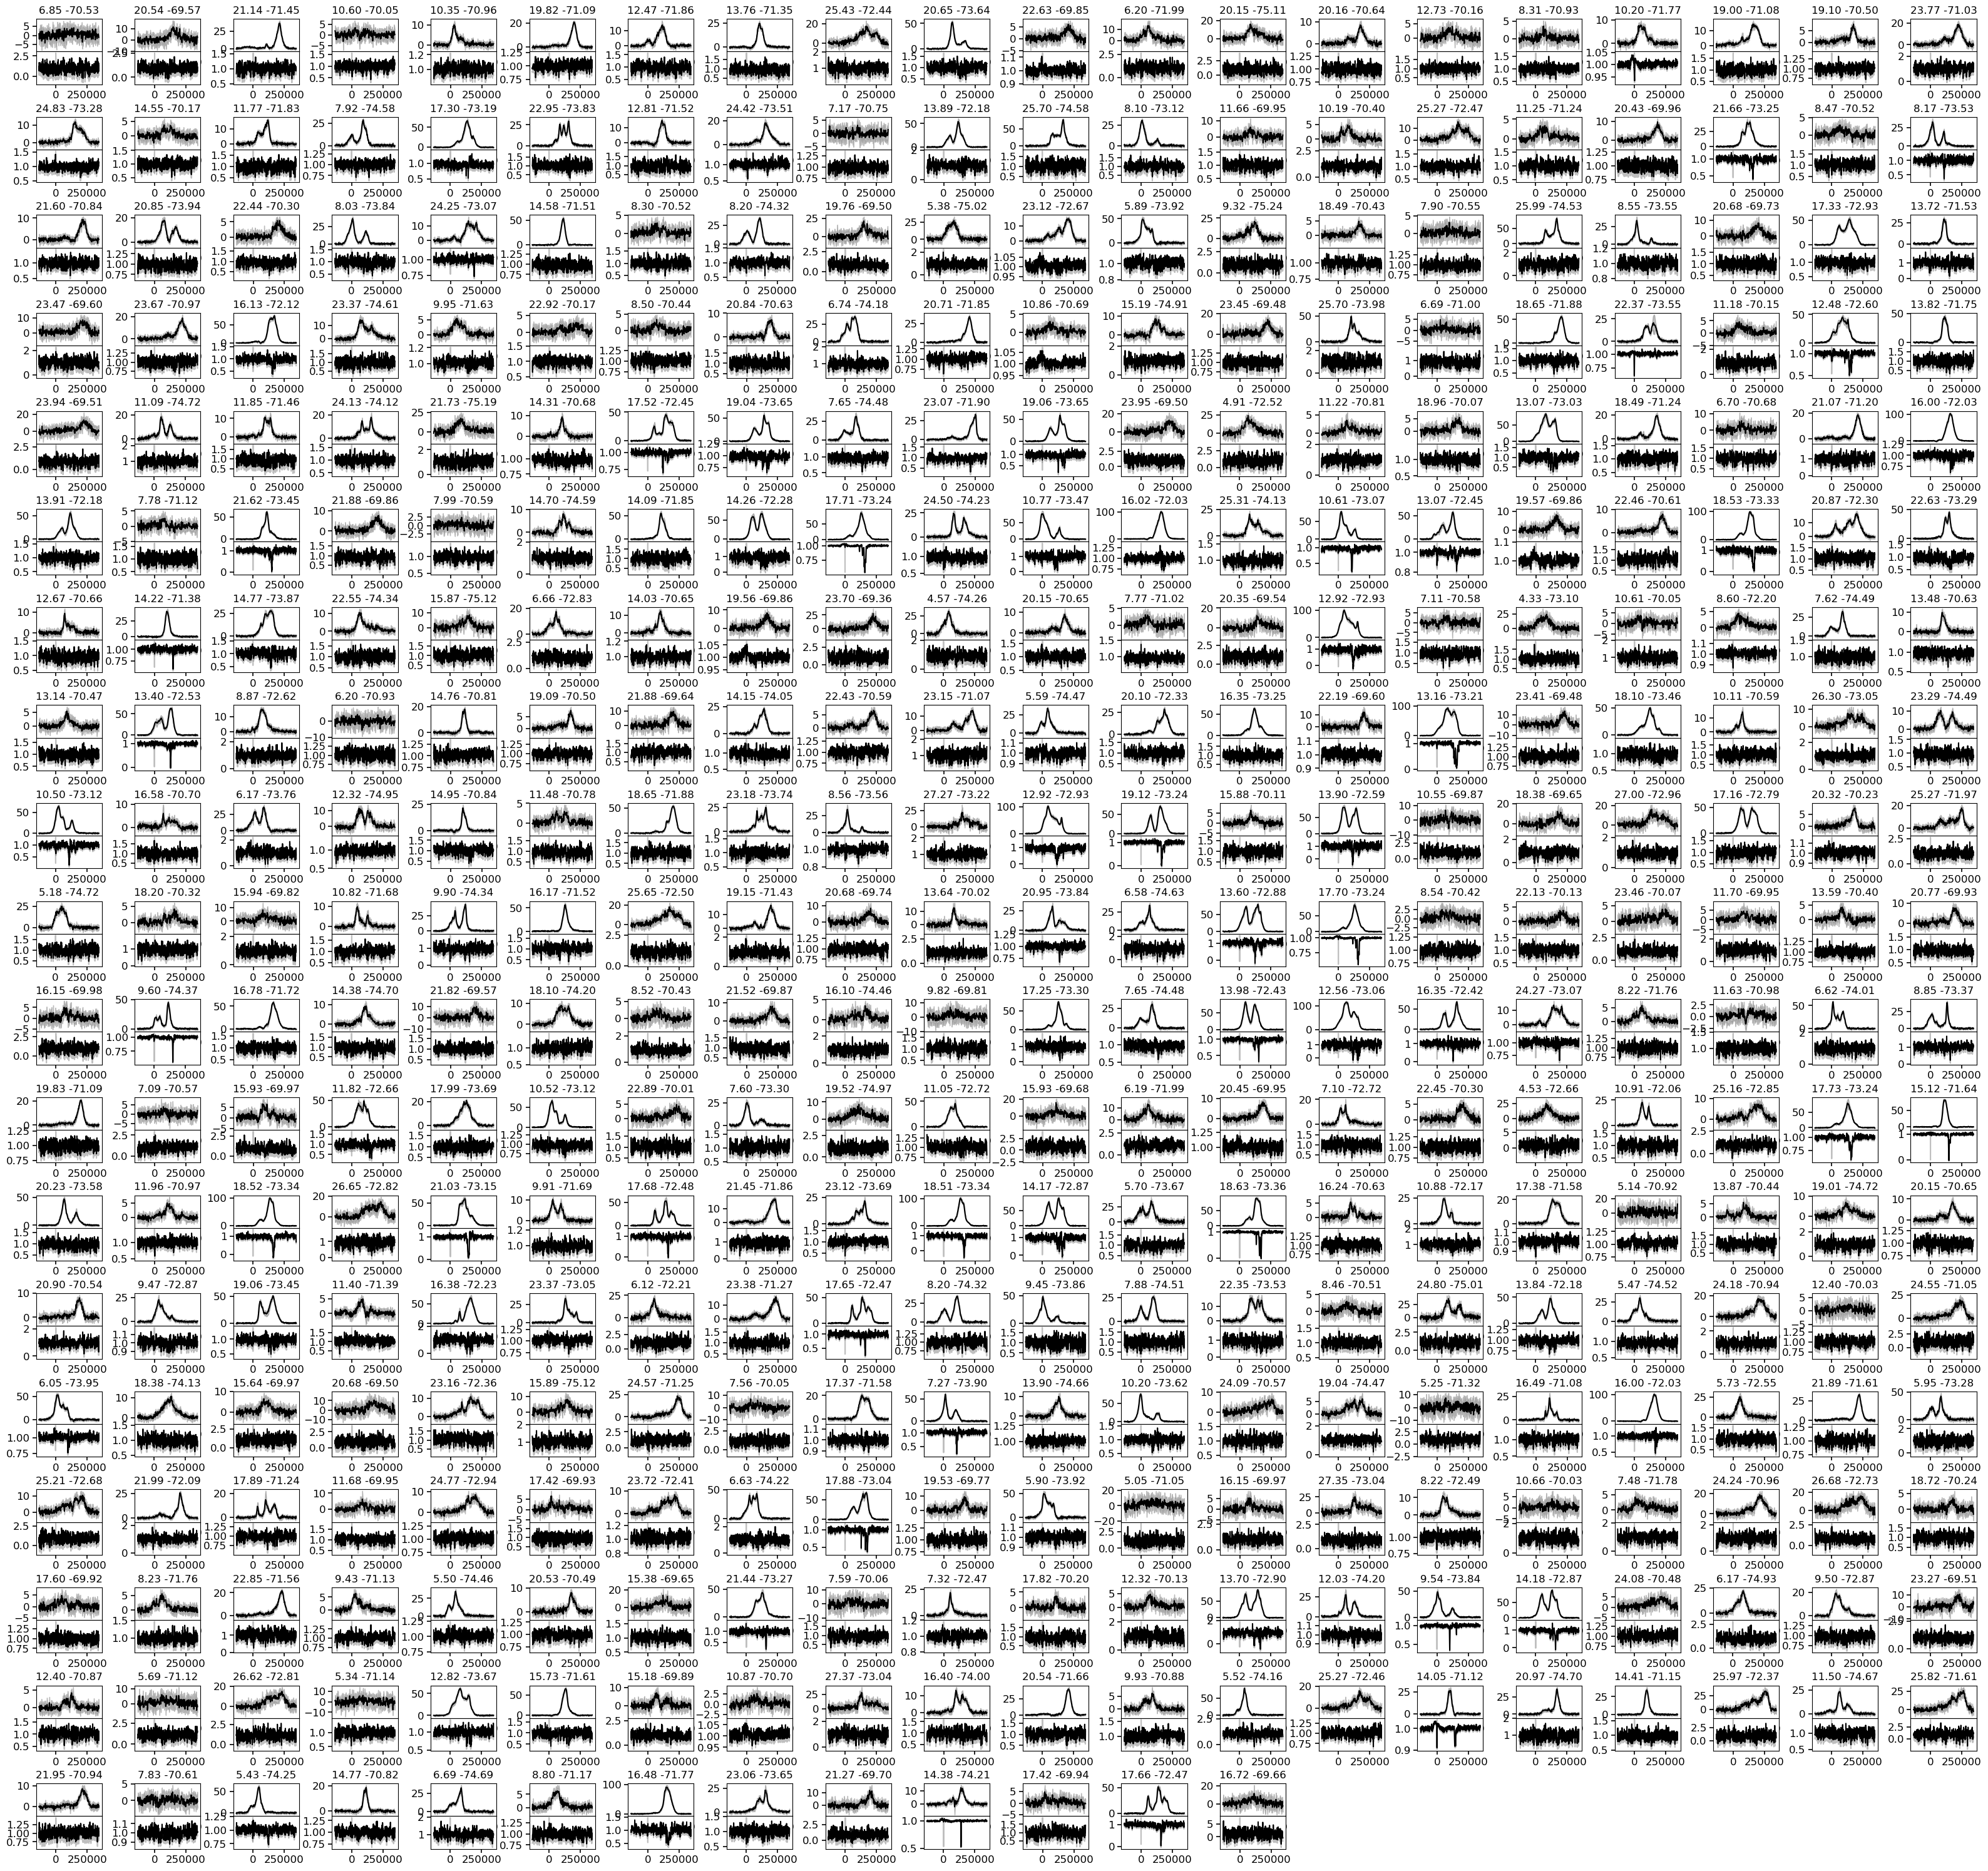

In [14]:
fig = plt.figure(figsize=(40,40), constrained_layout=False)
outer_grid = fig.add_gridspec(20,20, wspace=0.5, hspace=0.5)

for i in tqdm(range(len(spec_files))):
    inner_grid = outer_grid[i].subgridspec(2, 1, wspace=0., hspace=0.)

    ax_em = fig.add_subplot(inner_grid[0])
    ax_abs = fig.add_subplot(inner_grid[1])
    
#     print(len(v_tb[i]), len(v_tau[i]) )

    ax_em.plot(v_tb[i], tb[i], color='black', zorder=4)
    ax_em.fill_between(v_tb[i], tb[i]-tb_err[i], tb[i]+tb_err[i], color='grey', alpha=0.5, zorder=1)

    ax_abs.plot(v_tau[i], tau[i], color='black')
    ax_abs.plot(v_tau[i], tau[i]-tau_err[i], tau[i]+tau_err[i], color='grey', alpha=0.5, zorder=1)
        
    ax_em.set_title(str('{0:.2f}'.format(ra[i]))+' '+str('{0:.2f}'.format(dec[i])))

plt.tight_layout()

In [15]:
def component_counter(vel, spec, err, sigma, v_lims):
    all_vels = []

    # Smooth the interpolated spectrum by n channels 
    spec_sm = ndimage.gaussian_filter1d(spec, sigma)

    # Compute first derivative of the spectrum
    df_spec = np.gradient(spec_sm)
    spec_zc = np.where(np.diff(np.sign(df_spec)))[0]

    for zc in spec_zc:
        # if it is a maximum
        if (df_spec[zc-1] > df_spec[zc+1]):
            # and the spectral position is detected at 3sigma 
            if (spec[zc]>3*err[zc]) and (spec[zc-1]>2.8*err[zc-1]) and (spec[zc+1]>2.8*err[zc+1]):
                # and if the velocity is within the specified window
                if (vel[zc] >= v_lims[0]) and (vel[zc]<v_lims[1]): 
                    all_vels.append(vel[zc])


    return all_vels, df_spec

In [ ]:
fig = plt.figure(0,[60,60])

# set smc velocity limits
v_lims_smc = [70,250]
# set smoothing kernel size
sigma = 2

smc_vels = []

# loop through absorption files
for k in tqdm(range(len(spec_files))):
    vel = v_tau[k]/1000.
    optd = tau[k]
    err = tau_err[k]
    
    ax = fig.add_subplot(20,20,k+1)
    ax.plot(vel, 1.-optd, color='grey')
    ax.plot(vel, 3.*err, color='orange')
    
    all_vels, df_spec = component_counter(vel, (1.-optd), err, sigma, v_lims = v_lims_smc)
    ax.plot(vel, df_spec, color='dodgerblue')

    if len(all_vels)>0:
        for vel_max in all_vels:
            ax.axvline(vel_max, color='red', lw=5, alpha=0.4) 

    ax.set_xlim(v_lims_smc[0], v_lims_smc[1])
    ax.set_title(k)
    
    smc_vels = smc_vels + [all_vels]

plt.tight_layout()

<ipython-input-16-2e6926e46af1>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm(range(len(spec_files))):


In [ ]:
fig = plt.figure(0,[60,60])

smc_vels_em = []

# loop through absorption files
for k in tqdm(range(len(spec_files))):
    vel = v_tb[k]/1000.
    em = tb[k]
    err = tb_err[k]
    
    ax = fig.add_subplot(20,20,k+1)
    ax.plot(vel, em, color='grey')
    ax.plot(vel, 3*err, color='orange')
    
    all_vels, df_spec = component_counter(vel, em, err, sigma, v_lims = v_lims_smc)
    if len(all_vels)>0:
        for vel_max in all_vels:
            ax.axvline(vel_max, color='red', lw=2) 

    ax.set_xlim(v_lims_smc[0], v_lims_smc[1])
    ax.set_title(k)
    
    smc_vels_em = smc_vels_em + [all_vels]

plt.tight_layout()



In [ ]:
smc_vels_f = [item for sublist in smc_vels for item in sublist]
smc_vels_em_f = [item for sublist in smc_vels_em for item in sublist]

In [ ]:
fig = plt.figure(0,[12,5])

# absorption velocities
ax = fig.add_subplot(121, projection=w2)
ccmap = 'Greys'
ax.imshow(nhi_askap, cmap=ccmap, vmin=0, vmax=120, origin='lower', zorder=1)
ds = 50
for j in range(len(smc_vels)):
    nvels = len(smc_vels[j])
    if nvels>0:
        for k in range(nvels):
            im = ax.scatter(pixcoord_extract[0][j], pixcoord_extract[1][j], c = smc_vels[j][k], vmin=70, vmax=220, marker='o', s=10+k*ds, cmap='RdBu_r', edgecolor='black', lw=0.3, zorder=10-k)

ax.set_xlabel(r'$\rm RA\,(J2000)$')
ax.set_ylabel(r'$\rm Dec\,(J2000)$')
raax = ax.coords['ra']
decax = ax.coords['dec']
raax.set_major_formatter('dd')
decax.set_major_formatter('dd') 
ax.grid(color='grey', ls='dotted', zorder=1)
ax.set_xlim(-400,3300)
ax.set_ylim(-400,2700)

ax.text(0.06, 0.95,r"$\rm (a)$",
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes) 


# emission velocities
ax = fig.add_subplot(122, projection=w2)
imn = ax.imshow(nhi_askap, cmap=ccmap, vmin=0, vmax=120, origin='lower', zorder=1)
for j in range(len(smc_vels_em)):
    nvels = len(smc_vels_em[j])
    if nvels>0:
        for k in range(nvels):
            im = ax.scatter(pixcoord_extract[0][j], pixcoord_extract[1][j], c = smc_vels_em[j][k], vmin=70, vmax=220, marker='o', s=10+k*ds, cmap='RdBu_r', edgecolor='black', lw=0.3, zorder=10-k)

ax.set_xlabel(r'$\rm RA\,(J2000)$')
ax.set_ylabel(r'$\,$')
raax = ax.coords['ra']
decax = ax.coords['dec']
raax.set_major_formatter('dd')
decax.set_major_formatter('dd') 
ax.grid(color='grey', ls='dotted', zorder=1)
ax.set_xlim(-400,3300)
ax.set_ylim(-400,2700)

ax.text(0.06, 0.95,r"$\rm (b)$",
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes) 

cax =fig.add_axes([0.27, 0.8, 0.2, 0.03])
plt.colorbar(im, label=r'$v_{\rm c}\,\,[\rm km\,s^{-1}]$', cax=cax, orientation='horizontal')

cax =fig.add_axes([0.91, 0.15, 0.015, 0.7])
plt.colorbar(imn, label=r'$N({\rm HI})\rm\,(10^{20}\rm\,cm^{-2})$', cax=cax) 

plt.savefig('velocity_comparison_maps.pdf', format='pdf')

In [ ]:
def cdfhist(arr, bins):
    fh = np.histogram(np.array(arr), bins=np.array(bins), density=True)
    fh = fh[0] / np.sum(fh[0])
    fh = np.cumsum(fh)
    return fh

In [ ]:
def cdf_plotter(ax, arr, bins, key):
    if key=='abs':
        clr='dodgerblue'
        lstyl = 'solid'
        lww = 2
        leg_key = 'Absorption'
    if key=='em':
        clr='orange'
        lstyl='solid'
        lww=5
        leg_key = 'Emission'

    full = cdfhist(arr, bins) 
    
    arr = np.array(arr, dtype=float)
    nt = 10000
    n = len(arr)
    idx = np.array([i for i in range(n)]).astype(np.int64)

    mids = (bins[1:] + bins[0:-1]) / 2.
    
    full_all = []
    for j in range(nt):
        newids2 = np.random.choice(idx, n, replace=True)
        fh = cdfhist(arr[newids2], bins)  
        full_all = full_all + [np.array(fh)]

    full_all = np.transpose(full_all)

    fmin = np.zeros(len(bins[:-1]))
    fmax = np.zeros(len(bins[:-1]))
    full = np.zeros(len(bins[:-1]))
    
    for k in range(len(bins[:-1])):
        fmin[k] = np.percentile(full_all[k],1)
        fmax[k] = np.percentile(full_all[k],99)
        full[k] = np.percentile(full_all[k],50)

    ax.fill_between(bins[:-1], fmin, fmax, color=clr, alpha=0.2)
    ax.plot(bins[:-1],full, ls=lstyl, color=clr,lw=lww, alpha=0.8, zorder=4, label=leg_key)
    


In [ ]:
vbins = np.linspace(v_lims_smc[0], v_lims_smc[1], 30)

fig= plt.figure(0,[6,4])
ax = fig.add_subplot(111)

cdf_plotter(ax, np.array(smc_vels_f), vbins, 'abs')
cdf_plotter(ax, np.array(smc_vels_em_f), vbins, 'em')
plt.legend(loc='upper left')
plt.xlabel(r"$v_{c}\rm\,\,[km\,s^{-1}]$")
plt.ylabel("CDF")

plt.tight_layout()

plt.savefig('velocity_comparison_cdf.pdf', format='pdf')